# Exploratory Analysis

In [ ]:
# imports
%reload_ext autoreload
%autoreload 3

import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

### Open data

In [ ]:
# open shap data 
with open('data/classification_results/shap_values_stratifiedCV_shuffled.pkl', 'rb') as f:
    _shap_values = pickle.load(f)

# sift out shap, y_pred, y_test values
shap_keys = list(_shap_values.keys())[:3]
y_preds_keys = list(_shap_values.keys())[3:6]
y_test_keys = list(_shap_values.keys())[6:9]
test_indices_keys = list(_shap_values.keys())[9:12]

shap_values = {k:_shap_values[k] for k in shap_keys}
y_preds = {k[7:]:_shap_values[k] for k in y_preds_keys} # remove 'y_pred_'
y_tests = {k[7:]:_shap_values[k] for k in y_test_keys} # remove 'y_test_'
test_indices = {k[len('test_indices_'):]:_shap_values[k] for k in test_indices_keys} # remove 'test_indices_'

In [ ]:
# open data
# beta correlation source
correlation = pd.read_csv('data/classification_datasets/correlation_source.csv', index_col=0)
correlation = correlation.query('description == "hypnosis"')
correlation = correlation.query('condition.str.contains("experience")').reset_index(drop=True)
col_name = [col for col in correlation.columns if 'beta' in col]
correlation_beta = correlation[col_name]

# gamma power sensor
power = pd.read_csv('data/classification_datasets/power_sensor.csv', index_col=0)
power = power.query('description == "hypnosis"')
power = power.query('condition.str.contains("experience")').reset_index(drop=True)
col_name = [col for col in power.columns if 'gamma' in col]
power_gamma = power[col_name]

## Constantly misclassified trials
Why are some people constanlty misclassifed? What are the features common between these participants?

In [ ]:
# open behavioral data and convert it to long format
data_bh = pd.read_excel('data/PLB_HYP_data_MASTER.xlsx', header=0, index_col=0)
# drop time columns
col_time = [col for col in data_bh.columns if 'time' in col]
data_bh.drop(columns=col_time, inplace=True)
# list columns we want to keep
col = data_bh.loc[:, :'which_real_hypnosis'].columns.append(pd.Index(['hypnotizability_total', 'bids_id']))
data_bh = data_bh[col].reset_index().loc[9:].reset_index(drop=True)

# chenge expectancy columns name to match the dataframe
exp_idx = np.where(data_bh.columns.str.startswith('expectancy_') == True)[0]
data_bh.columns.values[exp_idx] = ['expectancy_tr_1', 'expectancy_tr_2', 'expectancy_tr_3', 'expectancy_tr_4']

# a list of columns we need to melt dataframe
col_filter = [i[:-1] for i in data_bh.columns[data_bh.columns.str.endswith('1')].tolist()]
col_filter = [col + f'{i}' for col in col_filter for i in range(1,5)]

data_bh_new = data_bh.copy()

new_columns = [c.split('_') if c in col_filter else (c, 'type', '1') for c in data_bh.columns]
data_bh_new.columns = pd.MultiIndex.from_tuples(new_columns)
data_bh_new.columns = data_bh_new.columns.droplevel(1)

data_bh_new = data_bh_new.stack(level=[0]).ffill(axis=1).T

data_bh_new = data_bh_new.unstack(0).reset_index()
data_bh_new = data_bh_new.pivot(index=['level_0','level_2'], columns='level_1', values=0).reset_index()

data_bh_new.rename(columns={'level_2':'session'}, inplace=True)
data_bh_new.drop(columns=['level_0'], inplace=True)
data_bh_new.set_index(['bids_id', 'session'], inplace=True)

In [ ]:
# Find constantly misclassified observations
model_name = 'power sensor (gamma)'

misclassified = np.where(y_tests[model_name] != y_preds[model_name])[0]
misclassified_obs = [i for i in range(103) if i in misclassified] # misclassified observations

# id of the observation in the original data that were misclassified more than 35 times (out of 40)
miss_idx = pd.DataFrame(test_indices[model_name]).iloc[misclassified].value_counts()
miss_idx = miss_idx[miss_idx > 35].index.tolist()
miss_idx = [miss_idx[i][0] for i in range(len(miss_idx))]
miss_idx.sort()

In [ ]:
# bids ids of miss classified observations in power data
miss_bids = power.loc[miss_idx][['bids_id', 'session']].values

# sift out the miss classified observations from behavioral data
miss_df = pd.DataFrame()

for i in range(len(miss_bids)):
    miss_df = pd.concat([miss_df, data_bh_new.loc[[miss_bids[i, 0]]].iloc[[miss_bids[i, 1] - 1]]])

<AxesSubplot:ylabel='Frequency'>

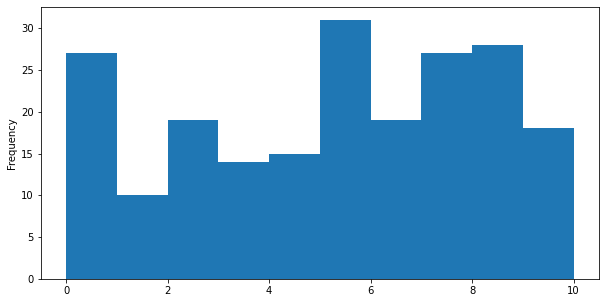

In [ ]:
# inspect miss classified observations
# it seems that there is a relationship between being misclassified and the expectancy

# expectancy
data_bh_new['expectancy'].plot(kind='hist', figsize=(10,5))
# miss_df['expectancy'].plot(kind='hist', bins=10, figsize=(10,5))

<AxesSubplot:ylabel='Frequency'>

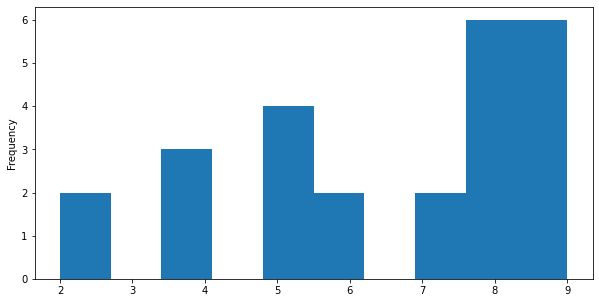

In [ ]:
miss_df['expectancy'].plot(kind='hist', bins=10, figsize=(10,5))

In [ ]:
col = 'felt_discomfort'
print(f'The percentage of participants reported discomfort \n IN TOTAL: \n {data_bh_new[col].value_counts(normalize=True)} \n MISCLASSIFIED: \n {miss_df.reset_index()[col].value_counts(normalize=True)}')

The percentage of participants reported discomfort 
 IN TOTAL: 
 No     0.692308
Yes    0.307692
Name: felt_discomfort, dtype: float64 
 MISCLASSIFIED: 
 No     0.68
Yes    0.32
Name: felt_discomfort, dtype: float64


In [ ]:
col = 'gender'
data_bh_new[col].value_counts(normalize=True), miss_df[col].value_counts(normalize=True)

(Female    0.75
 Male      0.25
 Name: gender, dtype: float64,
 Female    0.68
 Male      0.32
 Name: gender, dtype: float64)

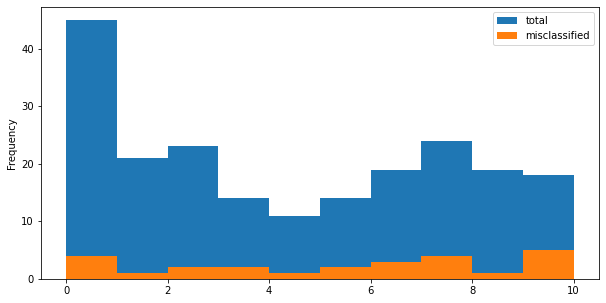

In [ ]:
col = 'hypnosis'
data_bh_new[col].plot(kind='hist', figsize=(10,5))
miss_df[col].plot(kind='hist', figsize=(10,5))
plt.legend(['total', 'misclassified'])

<AxesSubplot:ylabel='Frequency'>

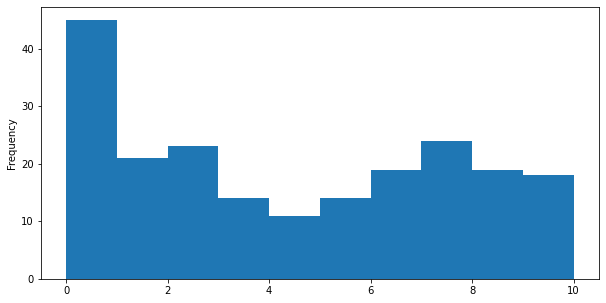

In [ ]:
data_bh_new[col].plot(kind='hist', figsize=(10,5))

<AxesSubplot:ylabel='Frequency'>

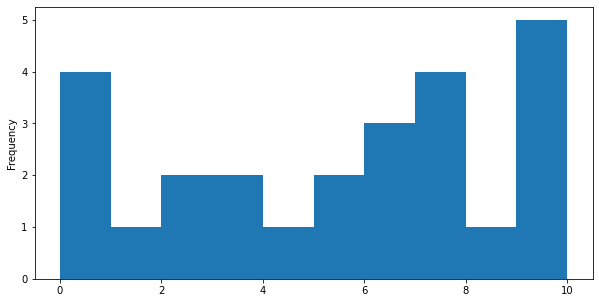

In [ ]:
col = 'hypnosis'
miss_df[col].plot(kind='hist', figsize=(10,5))

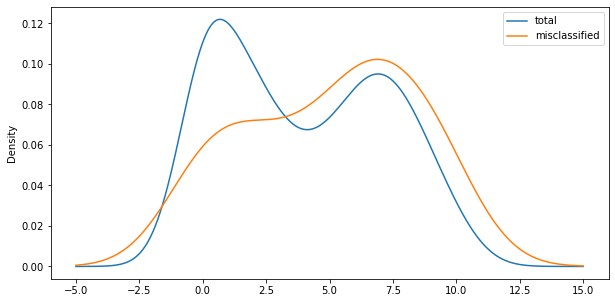

In [ ]:
data_bh_new[col].plot(kind='kde', figsize=(10,5))
miss_df.reset_index()[col].plot(kind='kde', figsize=(10,5))
plt.legend(['total', 'misclassified'])

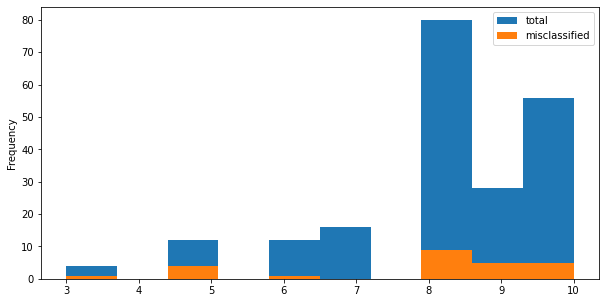

In [ ]:
col = 'motivation_to_get_hypnotized'
data_bh_new[col].plot(kind='hist', figsize=(10,5))
miss_df.reset_index()[col].plot(kind='hist', figsize=(10,5))
plt.legend(['total', 'misclassified'])

In [ ]:
col = 'procedure'
data_bh_new[col].value_counts(normalize=True).sort_values(), miss_df.reset_index()[col].value_counts(normalize=True)

(whitenoise    0.25
 relaxation    0.25
 confusion     0.25
 embedded      0.25
 Name: procedure, dtype: float64,
 whitenoise    0.40
 confusion     0.24
 embedded      0.20
 relaxation    0.16
 Name: procedure, dtype: float64)

In [ ]:
# white noise is no differnt than hypnosis if it is discribed as hypnosis??
# people would mostly rate themeseleves as high but their brain activity shows that they are not
miss_df.query('procedure == "whitenoise"')['hypnosis'].apply(lambda x: 1 if x >= 5 else 0).value_counts()

1    6
0    4
Name: hypnosis, dtype: int64

<AxesSubplot:ylabel='Frequency'>

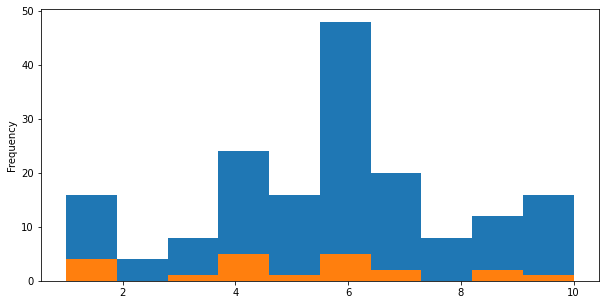

In [ ]:
col = 'hypnotizability_total'
data_bh_new[col].plot(kind='hist', figsize=(10,5))
miss_df.reset_index()[col].plot(kind='hist', figsize=(10,5))

In [ ]:
# people who are misclassified preferred relaxation over whitenoise
col = 'prefered_procedure'
data_bh_new[col].value_counts(normalize=True), miss_df.reset_index()[col].value_counts(normalize=True)

(whitenoise    0.307692
 confusion     0.269231
 relaxation    0.250000
 embedded      0.173077
 Name: prefered_procedure, dtype: float64,
 relaxation    0.36
 whitenoise    0.32
 confusion     0.24
 embedded      0.08
 Name: prefered_procedure, dtype: float64)

In [ ]:
col = 'suspected_control'
data_bh_new[col].value_counts(normalize=True), miss_df.reset_index()[col].value_counts(normalize=True)

(Yes    0.634615
 No     0.365385
 Name: suspected_control, dtype: float64,
 Yes    0.76
 No     0.24
 Name: suspected_control, dtype: float64)

In [ ]:
col = 'suspected_real_hypnosis'
data_bh_new[col].value_counts(normalize=True), miss_df.reset_index()[col].value_counts(normalize=True)

(Yes    0.634615
 No     0.365385
 Name: suspected_real_hypnosis, dtype: float64,
 Yes    0.68
 No     0.32
 Name: suspected_real_hypnosis, dtype: float64)

In [ ]:
col = 'trial'
data_bh_new[col].value_counts(normalize=True), miss_df.reset_index()[col].value_counts(normalize=True)

(sham    0.5
 True    0.5
 Name: trial, dtype: float64,
 sham    0.6
 True    0.4
 Name: trial, dtype: float64)

In [ ]:
col = 'which_real_control'
data_bh_new[col].value_counts(normalize=True), miss_df.reset_index()[col].value_counts(normalize=True)

(relaxation    0.431373
 confusion     0.294118
 whitenoise    0.176471
 embedded      0.098039
 Name: which_real_control, dtype: float64,
 relaxation    0.416667
 confusion     0.333333
 whitenoise    0.208333
 embedded      0.041667
 Name: which_real_control, dtype: float64)

### Decision of the misclassified participants
First, we plot the decision tree for the hypnotized participants who were classified as non-hypnotized. (in how many ways are the high participants misclassified?)

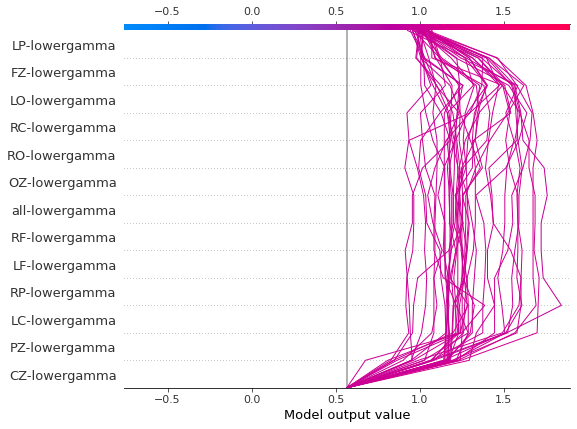

In [ ]:
# feature names
feature_names = [col for col in power_gamma.columns]
ind = pd.DataFrame(test_indices[model_name], columns=['test_indices']).iloc[misclassified].query('test_indices == 40').index.tolist()
# ind2 = pd.DataFrame(test_indices[model_name], columns=['test_indices']).iloc[misclassified].query('test_indices == 69').index.tolist()
# [ind.append(i) for i in ind2]
j = 5  # index of the misclassified observation
miss =  [misclassified_obs[j] + i * 103 for i in range(40)] # indices for one obseration from the 40 iterations

# decision plot
# TODO: fix decision plot with different base values #TODO: make decition values identical with stratified CV.
shap.decision_plot(shap_values[model_name].base_values[ind][0],
                   shap_values[model_name].values[ind],
                   shap_values[model_name].data[ind],
                   feature_order='hclust',
                   feature_display_range = slice(-1, -14, -1),
                   feature_names=feature_names,
                   ignore_warnings=True)